In [476]:
#подключим библиотеки
import pandas as pd
import phik
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import fbeta_score, make_scorer
#import category_encoders as ce

In [477]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
from ydata_profiling import ProfileReport

In [478]:
def read_data(path):
    text = 'Успешное создание DF: '
    try:
        df = pd.read_csv(path,sep=',')
        text += path
    except:
        try:
            df = pd.read_csv(path.split('/')[-1],sep=',')
            text += path.split('/')[-1]
        except:
            df = None
            text = 'Ошибка чтения файла!'
    print(text)
    return df

In [479]:
df = read_data('D:\study\master 1\datasets\kaggle_music_genre_train.csv')

Успешное создание DF: D:\study\master 1\datasets\kaggle_music_genre_train.csv


In [480]:
df_test = read_data('D:\study\master 1\datasets\kaggle_music_genre_test.csv')

Успешное создание DF: D:\study\master 1\datasets\kaggle_music_genre_test.csv


In [481]:
#ProfileReport(df)

**Выводы:**
- признаки, которые точно не нужны для построения модели **instance_id, track_name, obtained_date**
- пропуски в признаках **key, mode, tempo**
- мультиколинеарность у признаков **acousticness, energy, loudness**
- высокая доля нулевых значений у признака **instrumentalness** - 29.3%
- **duration_ms** - отрицательные значения, которые противоречат логике данных, высокая продолжительность некоторых треков (стоит проанализировать жанры для этих аномалий)
- **liveness, speechiness, loudness** - выбросы
- **mode** - в дальнейшем можно попробовать строить модель без данного признака, поскольку наличие лишь 2х значений вряд ли поможет точно охарактеризовать жанр, надо оценить в разрезе жанров

Удалим признаки **instance_id, track_name, obtained_date**, поскольку они могут только помешать при построении модели.

In [482]:
df.drop(['instance_id','track_name','obtained_date'],axis=1, inplace=True)

Изучим пропуски

In [483]:
df[['key', 'mode', 'tempo']].isnull().corr()

,key,mode,tempo
key,1.000000,0.006365,-0.008906
mode,0.006365,1.000000,-0.002092
tempo,-0.008906,-0.002092,1.000000


Зависимости между пропущенными значениями нет.

На первоначальном этапе заменим пропуски следующим образом:
- **key** - будем импользовать символ, который заведом не может быть использоват - **Z**
- **mode** - слово-заглушку **pusto** (оставим 5 символов, как в имеющихся значениях)
- **tempo** - установим медианное значение

In [484]:
df.fillna({'key':'Z', 'mode':'pusto','tempo':df['tempo'].median()}, inplace = True)
print('Пропусков в DF:', df.isnull().sum().sum())

Пропусков в DF: 0


In [10]:
df_copy = df.copy()

In [11]:
def sns_data(data):
    plt.figure(figsize = (2,2))
    sns.set_style("white")
    hist, ax = plt.subplots()
    ax = sns.histplot(data)
    ax.set_xlabel("Жанр")
    ax.set_ylabel("Частота")
    ax.set_title("Гистограмма распределения целевого признака.", fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

<Figure size 200x200 with 0 Axes>

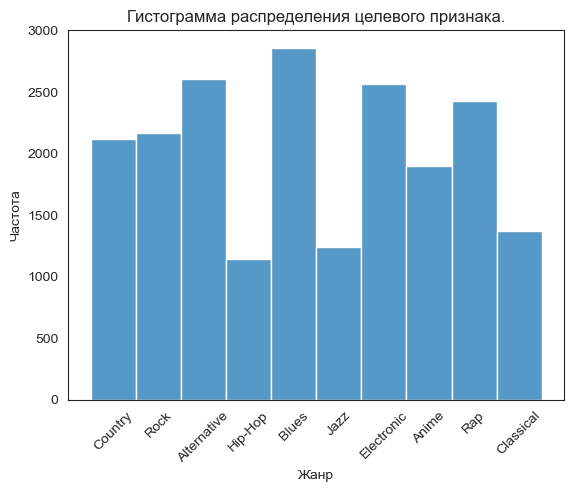

In [12]:
sns_data(df['music_genre'])

Познакомимся с предоставленными данными.

- наблюдаем явный дисбаланс классов
- реже всего встречаются жанры **hip-hop, jazz, classical**
- самый распространенный **blues**

Познакомимся с предоставленными данными.

In [13]:
df.groupby('music_genre').describe().style.background_gradient(cmap='Blues')

Добавим новые столбцы, изучив крайние значения признаков в разрезе жанров

In [14]:
#df['min_acousticness'] = 0
#df.loc[df['acousticness'] < 0.00008,'min_acousticness'] = 1

#df['max_acousticness'] = 0
#df.loc[df['acousticness'] > 0.910,'max_acousticness'] = 1

#df['max_instrumentalness'] = 0
#df.loc[df['instrumentalness'] > 0.750,'max_instrumentalness'] = 1

#df['min_danceability'] = 0
#df.loc[df['danceability'] < 0.197,'min_danceability'] = 1

#df['max_duration_ms'] = 0
#df.loc[df['duration_ms'] > 2020000,'max_duration_ms'] = 1

#df['min_energy'] = 0
#df.loc[df['energy'] < 0.1,'min_energy'] = 1

#df['min_loudness'] = 0
#df.loc[df['loudness'] < -31,'min_loudness'] = 1

#df['max_loudness'] = 0
#df.loc[df['loudness'] > 0,'max_loudness'] = 1

#df['min_tempo'] = 0
#df.loc[df['tempo'] < 40,'min_tempo'] = 1

In [15]:
buf = df['music_genre']
df.drop('music_genre', axis = 1, inplace = True)
df.insert(0, 'music_genre', buf)

In [16]:
df.drop(['mode','key'], axis = 1, inplace = True)

In [17]:
df.phik_matrix(verbose=False).style.format('{:.3f}').background_gradient(cmap='Blues')

,music_genre,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
music_genre,1.000,0.658,0.623,0.201,0.669,0.568,0.209,0.679,0.498,0.328,0.464
acousticness,0.658,1.000,0.458,0.134,0.767,0.442,0.186,0.709,0.204,0.333,0.397
danceability,0.623,0.458,1.000,0.171,0.516,0.343,0.135,0.483,0.336,0.400,0.532
duration_ms,0.201,0.134,0.171,1.000,0.143,0.172,0.087,0.169,0.035,0.074,0.142
energy,0.669,0.767,0.516,0.143,1.000,0.437,0.257,0.839,0.239,0.383,0.479
instrumentalness,0.568,0.442,0.343,0.172,0.437,1.000,0.138,0.498,0.191,0.216,0.357
liveness,0.209,0.186,0.135,0.087,0.257,0.138,1.000,0.199,0.139,0.085,0.131
loudness,0.679,0.709,0.483,0.169,0.839,0.498,0.199,1.000,0.211,0.352,0.437
speechiness,0.498,0.204,0.336,0.035,0.239,0.191,0.139,0.211,1.000,0.202,0.119
tempo,0.328,0.333,0.400,0.074,0.383,0.216,0.085,0.352,0.202,1.000,0.258


Избавимся от мультиколлинеарности заменив 3 признака **energy, loudness, acousticness** на один признак, равный среднему арифметическому данных признаков

In [18]:
#df.insert(1,'ael', (df['acousticness'] + df['energy'] + df['loudness'])/3)
#df.drop(['acousticness','energy','loudness'],axis=1, inplace=True)

In [19]:
df.phik_matrix(verbose=False).style.format('{:.3f}').background_gradient(cmap='Blues')

,music_genre,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
music_genre,1.000,0.658,0.623,0.201,0.669,0.568,0.209,0.679,0.498,0.328,0.464
acousticness,0.658,1.000,0.458,0.134,0.767,0.442,0.186,0.709,0.204,0.333,0.397
danceability,0.623,0.458,1.000,0.171,0.516,0.343,0.135,0.483,0.336,0.400,0.532
duration_ms,0.201,0.134,0.171,1.000,0.143,0.172,0.087,0.169,0.035,0.074,0.142
energy,0.669,0.767,0.516,0.143,1.000,0.437,0.257,0.839,0.239,0.383,0.479
instrumentalness,0.568,0.442,0.343,0.172,0.437,1.000,0.138,0.498,0.191,0.216,0.357
liveness,0.209,0.186,0.135,0.087,0.257,0.138,1.000,0.199,0.139,0.085,0.131
loudness,0.679,0.709,0.483,0.169,0.839,0.498,0.199,1.000,0.211,0.352,0.437
speechiness,0.498,0.204,0.336,0.035,0.239,0.191,0.139,0.211,1.000,0.202,0.119
tempo,0.328,0.333,0.400,0.074,0.383,0.216,0.085,0.352,0.202,1.000,0.258


Итак, мультиколлинеарность отсутсвует, пропуски тоже. Не нужные признаки удалены, приступим к моделированию.

## 2. Моделирование

Выделим в отдельный ДФ признаки и целевой признак.

In [20]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

In [21]:
def data_split(df, target):
    return  train_test_split(df.drop(target, axis = 1), df[target], test_size=0.25, random_state=12345)#, stratify=df['music_genre'])

In [22]:
X_train, X_test, y_train, y_test = data_split(df, 'music_genre')

In [23]:
scaler  = StandardScaler()

poly    = PolynomialFeatures(degree=2, include_bias=False)
#модели
LR  = LogisticRegressionCV(class_weight='balanced', multi_class='multinomial',n_jobs=-1,random_state=12345)
LR_s  = LogisticRegressionCV(class_weight='balanced', n_jobs=-1,random_state=12345)
#DT  = DecisionTreeClassifier(random_state=12345, class_weight = 'balanced') 
RFC = RandomForestClassifier(random_state=12345, class_weight = 'balanced',n_jobs=-1)
KNE = KNeighborsClassifier(n_jobs=-1)
etc = ExtraTreesClassifier(random_state=12345, class_weight = 'balanced',n_jobs=-1)
bern = BernoulliNB()
gaus = GaussianNB()

In [24]:
poly_pipeline = Pipeline([('poly', poly)])

#зададим pipline
lr_pipeline   = Pipeline([('LR', LR)])
#dt_pipeline  = Pipeline([('DT', DT)])
rfc_pipeline = Pipeline([('RFC', RFC)])
etc_pipeline = Pipeline([('etc', etc)])
kne_pipeline = Pipeline([('KNE', KNE)])
bern_pipeline = Pipeline([('bern', bern)])
gaus_pipeline = Pipeline([('gaus', gaus)])

In [25]:
list_pip = [lr_pipeline, rfc_pipeline, etc_pipeline, kne_pipeline,  bern_pipeline,
           gaus_pipeline] #dt_pipeline

In [26]:
list_metric = pd.DataFrame(columns=['LR','RFC','etc','KNE','bern','gaus']) # 'DT'

In [27]:
def test_models(X_train, y_train, X_test, y_test, ind):
    _list = []
    for pip in list_pip:
        print(pip.steps[0][0])
        pip.fit(X_train, y_train)
        y_pred = pip.predict(X_test)
        _list.append(round(fbeta_score(y_test, y_pred, average='macro', beta=0.5),5))
    list_metric.loc[ind] = _list

In [28]:
def OneVsRest(X_train, y_train, X_test, y_test, ind):
    _list = []
    for pip in list_pip:
        print(pip.steps[0][0])
        y_pred = OneVsRestClassifier(pip).fit(X_train, y_train).predict(X_test)
        _list.append(round(fbeta_score(y_test, y_pred, average='macro', beta=0.5),5))
    list_metric.loc[ind] = _list

In [106]:
def OneVsOne(X_train, y_train, X_test, y_test, ind):
    _list = []
    for pip in list_pip:
        print(pip.steps[0][0])
        try:
            y_pred = OneVsOneClassifier(pip).fit(X_train, y_train).predict(X_test)
            f = fbeta_score(y_test, y_pred, average='macro', beta=0.5)
        except: 
            f = 0
        _list.append(round(f,5))
    list_metric.loc[ind] = _list

In [30]:
test_models(X_train, y_train, X_test, y_test, 'not_changes')
lr_pipeline   = Pipeline([('LR', LR_s)])
OneVsRest(X_train, y_train, X_test, y_test, 'OneVsRest')
OneVsOne(X_train, y_train, X_test, y_test, 'OneVsOne')

LR
RFC
etc
KNE
bern
gaus
LR
RFC
etc
KNE
bern
gaus
LR
RFC
etc
KNE
bern
gaus


In [31]:
list_metric

,LR,RFC,etc,KNE,bern,gaus
not_changes,0.08217,0.42067,0.41785,0.13716,0.05101,0.17134
OneVsRest,0.12081,0.42245,0.42146,0.14138,0.05101,0.16380
OneVsOne,0.14786,0.42842,0.42295,0.14475,0.05101,0.17892


In [32]:
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler =  scaler.transform(X_test)

In [33]:
OneVsRest(X_train_scaler, y_train, X_test_scaler, y_test, 'OneVsRest_scaler')
OneVsOne(X_train_scaler, y_train, X_test_scaler, y_test, 'OneVsOne_scaler')
lr_pipeline   = Pipeline([('LR', LR)])
test_models(X_train_scaler, y_train, X_test_scaler, y_test, 'not_changes_scaler')

LR
RFC
etc
KNE
bern
gaus
LR
RFC
etc
KNE
bern
gaus
LR
RFC
etc
KNE
bern
gaus


In [34]:
list_metric.style.format('{:.3f}').background_gradient(cmap='Blues')

,LR,RFC,etc,KNE,bern,gaus
not_changes,0.082,0.421,0.418,0.137,0.051,0.171
OneVsRest,0.121,0.422,0.421,0.141,0.051,0.164
OneVsOne,0.148,0.428,0.423,0.145,0.051,0.179
OneVsRest_scaler,0.361,0.418,0.419,0.377,0.275,0.290
OneVsOne_scaler,0.381,0.428,0.425,0.390,0.280,0.301
not_changes_scaler,0.371,0.423,0.415,0.379,0.280,0.301


In [35]:
def drop_col_emissions(df, to_del):
    print('    Исходное число записей:', len(df))
    print('    Будет удалено', len(to_del))
    df.drop(to_del.index, inplace = True)
    print('    Итоговое число записей:', len(df))
    return df

def drop_emissions(df, emissions_col):
#   new_emissions_col = emissions_col
    for col in emissions_col:
        q1 = df[col].quantile(q=0.25)
        q3 = df[col].quantile(q=0.75)
        iqr= q3 - q1
        lower_emission = q1 - (1.5*iqr)
        upper_emission = q3 + (1.5*iqr)
        if lower_emission == upper_emission:
            continue
#        new_emissions_col.remove(col)
        print(f'{col}: нижняя граница - {lower_emission}, верхняя граница - {upper_emission}')
        to_del = df.loc[(lower_emission > df[col]) | (df[col] > upper_emission)]
        df = drop_col_emissions(df, to_del)
  
#    return new_emissions_col

In [36]:
df_buf = df.copy()
emissions_col = drop_emissions(df_buf, df_buf.drop(['music_genre','instrumentalness','duration_ms','speechiness'], axis=1).columns)

acousticness: нижняя граница - -0.6669999999999999, верхняя граница - 1.1522
    Исходное число записей: 20394
    Будет удалено 0
    Итоговое число записей: 20394
danceability: нижняя граница - 0.10300000000000015, верхняя граница - 1.0309999999999997
    Исходное число записей: 20394
    Будет удалено 117
    Итоговое число записей: 20277
energy: нижняя граница - -0.06399999999999995, верхняя граница - 1.3679999999999999
    Исходное число записей: 20277
    Будет удалено 0
    Итоговое число записей: 20277
liveness: нижняя граница - -0.1375, верхняя граница - 0.4889
    Исходное число записей: 20277
    Будет удалено 1302
    Итоговое число записей: 18975
loudness: нижняя граница - -17.942249999999998, верхняя граница - 2.691749999999998
    Исходное число записей: 18975
    Будет удалено 1212
    Итоговое число записей: 17763
tempo: нижняя граница - 31.153749999999974, верхняя граница - 209.37175000000005
    Исходное число записей: 17763
    Будет удалено 7
    Итоговое число зап

In [37]:
X_train, X_test, y_train, y_test = data_split(df_buf, 'music_genre')
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler =  scaler.transform(X_test)

In [38]:
lr_pipeline   = Pipeline([('LR', LR_s)])
OneVsOne(X_train_scaler, y_train, X_test_scaler, y_test, 'OneVsOne_emis')

LR
RFC
etc
KNE
bern
gaus


In [39]:
list_metric.style.format('{:.3f}').background_gradient(cmap='Blues')

,LR,RFC,etc,KNE,bern,gaus
not_changes,0.082,0.421,0.418,0.137,0.051,0.171
OneVsRest,0.121,0.422,0.421,0.141,0.051,0.164
OneVsOne,0.148,0.428,0.423,0.145,0.051,0.179
OneVsRest_scaler,0.361,0.418,0.419,0.377,0.275,0.290
OneVsOne_scaler,0.381,0.428,0.425,0.390,0.280,0.301
not_changes_scaler,0.371,0.423,0.415,0.379,0.280,0.301
OneVsOne_emis,0.330,0.404,0.399,0.353,0.257,0.256


In [37]:

fbeta = make_scorer(fbeta_score, beta=0.5, average='macro')

X = df_copy.drop('music_genre', axis=1).values 
y = df_copy.music_genre.values

ordinal = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
X = ordinal.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def objective(trial):
    criterions = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depths = trial.suggest_int('max_depth', 1, 20, 1)
    n_estimators = trial.suggest_int('n_estimators', 10, 1000, 10)

    clf = RandomForestClassifier(n_estimators=n_estimators,
                                 criterion=criterions, 
                                 max_depth=max_depths,
                                 n_jobs = -1,
                                 random_state = 12345,
                                 class_weight = 'balanced')
    
    score = cross_val_score(clf, X_scaled, y, scoring=fbeta).mean()

    return score

study = optuna.create_study(study_name="randomForest_optimization",
                            direction="maximize",
                            sampler=TPESampler())
study.optimize(objective, n_trials=10, timeout=1800)

In [38]:
print(study.best_params)
print(study.best_value)

{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 140}
0.4257314528739856


In [107]:
OneVsOne(X_train, y_train, X_test, y_test, 'OneVsOne_ohe_scaler')

LR
RFC
etc
KNE
bern
gaus


In [108]:
list_metric.style.format('{:.3f}').background_gradient(cmap='Blues')

,LR,RFC,etc,KNE,bern,gaus
not_changes,0.082,0.421,0.418,0.137,0.051,0.171
OneVsRest,0.121,0.422,0.421,0.141,0.051,0.164
OneVsOne,0.148,0.428,0.423,0.145,0.051,0.179
OneVsRest_scaler,0.361,0.418,0.419,0.377,0.275,0.290
OneVsOne_scaler,0.381,0.428,0.425,0.390,0.280,0.301
not_changes_scaler,0.371,0.423,0.415,0.379,0.280,0.301
OneVsOne_emis,0.330,0.404,0.399,0.353,0.257,0.256
OneVsOne_ohe_scaler,0.392,0.419,0.405,0.000,0.285,0.314


In [30]:

X_train, X_test, y_train, y_test = data_split(df_copy, 'music_genre')

CBC = CatBoostClassifier(
    iterations=150,
    random_seed=12345,
    loss_function='MultiClass',
)

pool_train = Pool(X_train, y_train, cat_features = ['key','mode'])
pool_test = Pool(X_test, y_test, cat_features = ['key','mode'])

CBC.fit(
    pool_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=False
)


y_pred = CBC.predict(pool_test)
round(fbeta_score(y_test, y_pred, average='macro', beta=0.5),5)

0.43785

In [93]:
CBC.get_feature_importance(prettified=True)

,Feature Id,Importances
0,instrumentalness,16.271139
1,danceability,14.527817
2,speechiness,11.818118
3,acousticness,9.885672
4,loudness,9.492256
5,valence,8.625900
6,energy,8.188820
7,duration_ms,7.556489
8,tempo,3.858763
9,mode,3.509271


In [507]:
df_test = read_data('D:\study\master 1\datasets\kaggle_music_genre_test.csv')

Успешное создание DF: D:\study\master 1\datasets\kaggle_music_genre_test.csv


In [ ]:
X_train, X_test, y_train, y_test = data_split(df_copy, 'music_genre')

In [486]:
df_test.drop(['instance_id','track_name','obtained_date'],axis=1, inplace=True)

df_test.fillna({'key':'Z', 'mode':'pusto','tempo':df['tempo'].median()}, inplace = True)
print('Пропусков в DF:', df.isnull().sum().sum())

Пропусков в DF: 0


In [487]:
X_train = df.drop('music_genre',axis=1)
y_train = df['music_genre']
X_test  = df_test

In [488]:
CBC = CatBoostClassifier(
    iterations=475,
    random_seed=12345,
    loss_function='MultiClass',
#    learning_rate= 0.027583475549166746,
#    depth= 4,
#    l2_leaf_reg= 1.0551779964424746e-05,
    bootstrap_type= 'Bayesian',
 #   random_strength= 2.0931628460945333e-07,
#    subsample= 0.1377216650303579,
 #   colsample_bylevel= 0.22694720080878733,
 #   min_data_in_leaf= 35,
 #   bagging_temperature= 3.9676747423066994,
 #   od_type= 'IncToDec',
 #   od_wait= 38
)

pool_train = Pool(X_train, y_train, cat_features = ['key','mode'])
#pool_test = Pool(X_test, y_test, cat_features = ['key','mode'])

CBC.fit(
    pool_train,
#    eval_set=(X_test, y_test),
    verbose=False,
    plot=False
)


y_pred = CBC.predict(X_test)
#round(fbeta_score(y_test, y_pred, average='macro', beta=0.5),5)

In [504]:
#pd.DataFrame(y_pred,index = X_test.index,columns = ['music_genre']).to_csv(r'D:\results.csv')

In [515]:
df_test = read_data('D:\study\master 1\datasets\kaggle_music_genre_test.csv')

Успешное создание DF: D:\study\master 1\datasets\kaggle_music_genre_test.csv


In [532]:
l = pd.DataFrame(y_pred,index = df_test.index,columns = ['music_genre'])
print(l)
l.index = df_test['instance_id'] 
print(l)
#l.reset_index()
#print(l.head())
#l.reset_index()
#l.set_index('instance_id')
#l.reset_index()
#l.index.rename('instance_id',inplace=True)
l.to_csv(r'D:\results.csv')

      music_genre
0             Rap
1           Blues
2             Rap
3         Country
4     Alternative
...           ...
5094      Country
5095          Rap
5096          Rap
5097   Electronic
5098         Jazz

[5099 rows x 1 columns]
             music_genre
instance_id             
48564                Rap
72394              Blues
88081                Rap
78331            Country
72636        Alternative
...                  ...
50532            Country
26255                Rap
67924                Rap
79778         Electronic
47986               Jazz

[5099 rows x 1 columns]


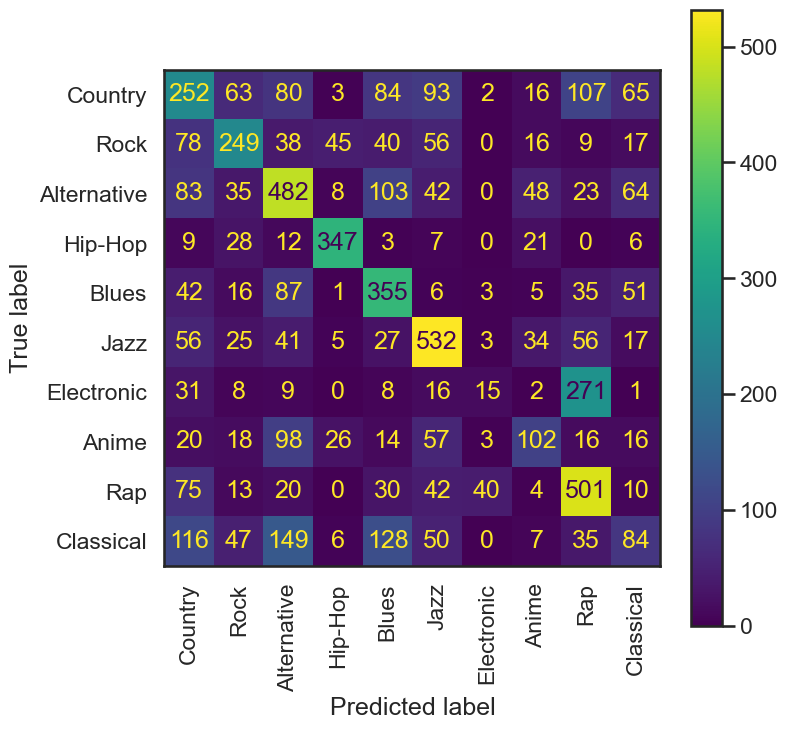

In [156]:
class_names  = df_copy['music_genre'].unique()
fig, ax = plt.subplots(figsize=(8, 8))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=class_names
)

cmp.plot(ax=ax, xticks_rotation= 'vertical')
plt.show();

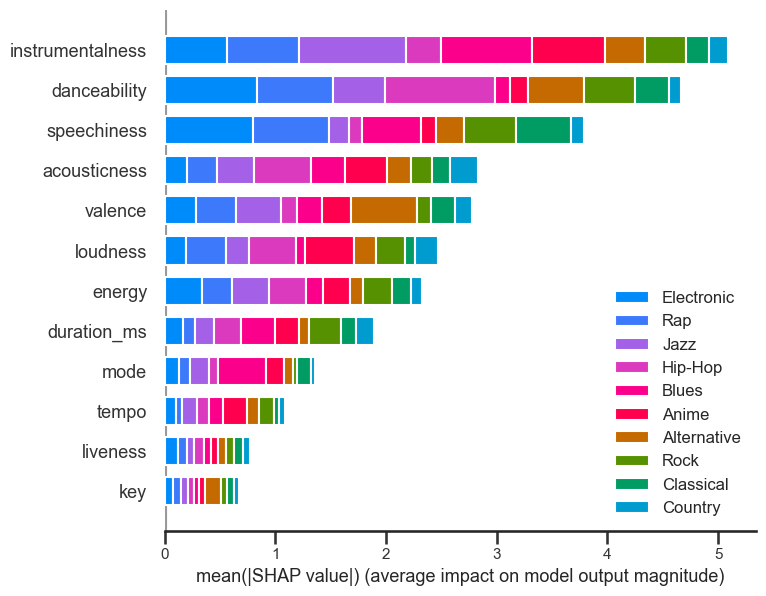

In [148]:
import shap


X = df_copy.drop('music_genre', axis = 1)
explainer = shap.TreeExplainer(CBC)
shap_values = explainer.shap_values(X)

class_names  = df_copy['music_genre'].unique()
shap.summary_plot(shap_values, X, plot_type='bar',  class_names= class_names, feature_names = X.columns)

In [469]:
X_train, X_test, y_train, y_test = data_split(df_copy, 'music_genre')

In [534]:
import optuna

def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    
    pool_train = Pool(X_train, y_train, cat_features = ['key','mode'])
    model.fit(pool_train)
    y_pred = model.predict(X_test)
    f = round(fbeta_score(y_test, y_pred, average='macro', beta=0.5),5)
    return f 

In [ ]:
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
model = CatBoostClassifier(**trial.params, verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
round(fbeta_score(y_test, y_pred, average='macro', beta=0.5),5)

In [77]:


X_train, X_test, y_train, y_test = data_split(df, 'music_genre')
    
      
from lightgbm import LGBMClassifier



model = LGBMClassifier(objective='multiclass', random_state=12345, n_jobs = -1,force_row_wise=True)
# тренируем модель на всём наборе данных

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
round(fbeta_score(y_test, y_pred, average='macro', beta=0.5),5)

[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 14275, number of used features: 10
[LightGBM] [Info] Start training from score -2.050920
[LightGBM] [Info] Start training from score -2.356185
[LightGBM] [Info] Start training from score -1.980476
[LightGBM] [Info] Start training from score -2.720385
[LightGBM] [Info] Start training from score -2.240458
[LightGBM] [Info] Start training from score -2.088661
[LightGBM] [Info] Start training from score -2.901856
[LightGBM] [Info] Start training from score -2.798922
[LightGBM] [Info] Start training from score -2.132008
[LightGBM] [Info] Start training from score -2.224781


0.42768

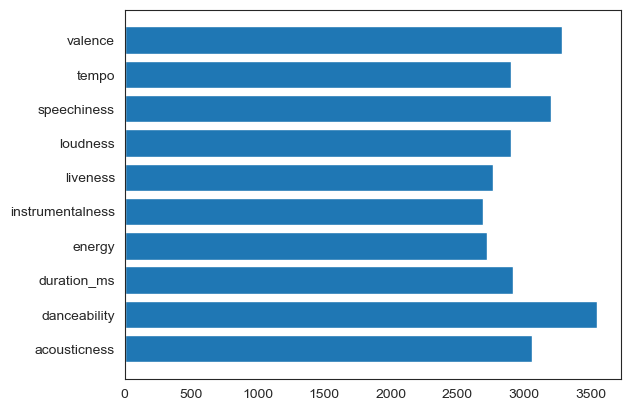

In [79]:
features = X_train.columns
importance_values = model.feature_importances_
plt.barh(y=range(len(features)),
width=importance_values,
tick_label=features)
plt.show()

In [86]:
y_train.unique()

array(['Rap', 'Rock', 'Country', 'Blues', 'Classical', 'Electronic',
       'Anime', 'Alternative', 'Hip-Hop', 'Jazz'], dtype=object)

In [91]:


X_train, X_test, y_train, y_test = data_split(df, 'music_genre')    
        
# xgboost для классификации

from xgboost import XGBClassifier

# определяем датасет

genre = {'Alternative': 0,
             'Anime': 1, 
             'Blues': 2,
                'Classical': 3,
             'Country': 4, 
             'Electronic': 5,
            'Jazz': 6,
             'Hip-Hop': 7, 
             'Rap': 8,
            'Rock': 9}

y_train = y_train.map(genre) # re-mapping
y_test = y_test.map(genre) # re-mapping


model = XGBClassifier(objective='multi:softmax', 
                            num_class=10
                     )

model.fit(X_train, y_train,verbose=0)
y_pred = model.predict(X_test)
round(fbeta_score(y_test, y_pred, average='macro', beta=0.5),5)

0.42837

In [35]:
##Определим функцию для изучения значимости признаков
def feature_importance(model, x_train):
    feats = {}
    for feature, importance in zip(x_train.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    return importances

In [58]:
df_features = feature_importance(RFC, X_train)
df_features

,Features,Gini-Importance
0,acousticness,0.118175
1,loudness,0.115763
2,danceability,0.114498
3,speechiness,0.114057
4,instrumentalness,0.105081
5,energy,0.099076
6,valence,0.093407
7,duration_ms,0.087461
8,tempo,0.078230
9,liveness,0.074254


In [ ]:
lr_parameters = {
    'LR__max_iter': [20, 50, 100, 200, 300, 500],                      
    'LR__solver': ['lbfgs', 'newton-cg', 'saga', 'sag', 'newton-cholesky', 'liblinear'],   
    'LR__penalty': ['l1','l2'],
    'LR__C': [0.01, 0.1, 1, 10, 100]
}
LR_N_ITER = 10

In [48]:
df

,music_genre,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,Country,0.48000,0.670,182653.0,0.351,0.017600,0.1150,-16.842,0.0463,101.384,0.450
1,Rock,0.24300,0.452,187133.0,0.670,0.000051,0.1080,-8.392,0.0352,113.071,0.539
2,Alternative,0.22800,0.454,173448.0,0.804,0.000000,0.1810,-5.225,0.3710,80.980,0.344
3,Hip-Hop,0.05580,0.847,255987.0,0.873,0.000003,0.3250,-4.805,0.0804,116.007,0.966
4,Alternative,0.22700,0.742,195333.0,0.575,0.000002,0.1760,-5.550,0.0487,76.494,0.583
...,...,...,...,...,...,...,...,...,...,...,...
20389,Jazz,0.71900,0.725,-1.0,0.483,0.000000,0.0797,-13.314,0.0438,87.413,0.942
20390,Rock,0.19000,0.482,198933.0,0.362,0.005620,0.0913,-10.358,0.0299,76.879,0.174
20391,Alternative,0.00061,0.663,220947.0,0.886,0.000025,0.2840,-4.149,0.0358,146.803,0.942
20392,Rap,0.00310,0.914,162214.0,0.515,0.000000,0.1050,-9.934,0.3560,150.016,0.215


In [25]:
df_copy['music_genre'].unique()

array(['Country', 'Rock', 'Alternative', 'Hip-Hop', 'Blues', 'Jazz',
       'Electronic', 'Anime', 'Rap', 'Classical'], dtype=object)

На первом этапе были протестированы классы по принципу 1 проти всех.
Таким образом, была выстроена иерархия вероятности предсказания класса от более высокой к низкой.

Затем пытаемся объединить жанры, чтобы повысить точность предсказания.

In [123]:
model_CBC = CatBoostClassifier(
                random_seed=12345,
                iterations=150,
                loss_function='MultiClass'
            )

In [124]:
def make_catboost(x_train,y_train,x_test,y_test,with_test):
    pool_train = Pool(x_train, y_train, cat_features = ['key','mode'])
    
   
    model_CBC.fit(pool_train,verbose=False, plot=False)
    y_pred = model_CBC.predict(x_test)

    if with_test:
        fbeta = round(fbeta_score(y_test, y_pred, average='macro', beta=0.5),5)
    else:
        fbeta = 0  

    y_pred =  pd.DataFrame(y_pred, index = x_test.index)
    return y_pred, fbeta

In [125]:
def predict_genre(X_train, X_test, Y_train, Y_test, range_genre, with_test=True):
    x_train = X_train.copy()
    y_train = Y_train.copy()
    x_test  = X_test.copy()
    Y_pred  = pd.Series(index = x_test.index, dtype  = object)
    if with_test:
        y_test = Y_test.copy()
    for genre in range_genre[:-1]:
        #зададим данные по приципу класс genre против всех
        y_train.loc[y_train != genre] = 'union'
        if with_test:
            y_test.loc[y_test != genre] = 'union'
        
        #предскажем
        y_pred, fbeta = make_catboost(x_train,y_train,x_test,y_test,with_test)

        print('--', genre,' fbeta: ', fbeta)
        Y_pred[y_pred[y_pred[0] == genre].index] = genre     
        #уберем проверенный жанр из данных
        y_pred = y_pred.loc[y_pred[y_pred[0] != genre].index]
        x_test = x_test.loc[y_pred.index]

        if with_test:
            y_test = y_test[y_pred.index]
            y_test = Y_test[y_test.index] 

        #добавим предсказания   
        Y_train = Y_train[Y_train != genre]  
        y_train = Y_train.copy()
        x_train = x_train.loc[y_train.index]
    Y_pred.loc[x_test.index] = range_genre[-1]     
    return Y_pred

In [126]:
range_genre = ['Classical','Electronic','Anime','Rap','Country','Blues','Jazz','Rock','Alternative','Hip-Hop']

Разделим выборки для тестирования

In [127]:
X_train, X_test, Y_train, Y_test = data_split(df_copy, 'music_genre')
_y_test = Y_test.copy()

5099

In [128]:
Y_pred = predict_genre(X_train, X_test, Y_train, Y_test, range_genre, with_test=True)

-- Classical  fbeta:  0.91451
-- Electronic  fbeta:  0.79957
-- Anime  fbeta:  0.72759
-- Rap  fbeta:  0.70288
-- Country  fbeta:  0.71093
-- Blues  fbeta:  0.67459
-- Jazz  fbeta:  0.65488
-- Rock  fbeta:  0.52668
-- Alternative  fbeta:  0.41477


In [129]:
def predict_test(x_train,y_train,x_test,y_test,_list):
    Y = y_train.copy()
    y = y_test.copy()
    Y[Y.isin(_list)] = 'test'
    Y[Y != 'test'] = 'union'

    y[y.isin(_list)] = 'test'
    y[y != 'test'] = 'union'
    return make_catboost(x_train,Y,x_test,y,True)

In [130]:
def learn_FP(y_test, y_pred, _list):
    pp = y_pred[y_pred[0]=='test'][0]
    pp = y_test.loc[pp.index]
    return pp[~pp.isin(_list)].value_counts()

In [131]:
def drop_genres(df_copy, _list):
    df_test = df_copy.copy()
    return df_test[~df_test['music_genre'].isin(_list)]   

In [132]:
#переделать на рекурсию
def test_FP(x_train,y_train,x_test,y_test, genre_list, test_list):
    f_max = 0
    best_list = []
    for g in test_list:
        _list = genre_list + list(g.split(" "))
        _y_pred, f = predict_test(x_train,y_train,x_test,y_test,_list)
        if f > f_max:
            f_max = f
            best_list = _list
        
        g1_list = test_list[test_list.index(g)+1:]
        for g1 in g1_list:
            _list1 = _list + list(g1.split(" "))
            _y_pred, f = predict_test(x_train,y_train,x_test,y_test,_list1)
            if f > f_max:
                f_max = f
                best_list = _list1 
        
            g2_list = test_list[test_list.index(g1)+1:]
            for g2 in g2_list:
                _list2 = _list1 + list(g2.split(" "))
                _y_pred, f = predict_test(x_train,y_train,x_test,y_test,_list2)
                if f > f_max:
                    f_max = f
                    best_list = _list2 
            
                g3_list = test_list[test_list.index(g2)+1:]
                for g3 in g3_list:
                    _list3 = _list2 + list(g3.split(" "))
                    _y_pred, f = predict_test(x_train,y_train,x_test,y_test,_list3)
                    if f > f_max:
                        f_max = f
                        best_list = _list3
                    
                    g4_list = test_list[test_list.index(g3)+1:]
                    for g4 in g4_list:
                        _list4 = _list3 + list(g4.split(" "))
                        _y_pred, f = predict_test(x_train,y_train,x_test,y_test,_list4)
                        if f > f_max:
                            f_max = f
                            best_list = _list4
    print(f_max,best_list)

In [133]:
def claster(X_train, y_train, n_clusters):
    x_train = X_train.copy()
    try:
        x_train.drop(['key','mode'],axis=1, inplace = True)
    except:
        pass

    sc = StandardScaler()
    sc.fit(x_train)
    X_train_sc = pd.DataFrame(sc.transform(x_train), index =  x_train.index, columns = x_train.columns)

    from sklearn.cluster import AgglomerativeClustering

    ward = AgglomerativeClustering(n_clusters= n_clusters,
                                   linkage="ward")
    ward.fit(X_train_sc)

    complete = AgglomerativeClustering(n_clusters=n_clusters,
                                       metric = 'euclidean',
                                       linkage="average")
    
    complete.fit(X_train_sc)
    return ward.labels_, complete.labels_

In [134]:
def print_labels(_label, x_train):
    labels = pd.Series(_label, index = x_train.index)
    labels.unique()
    for i in range(len(labels.unique())):
        ind = x_train.loc[labels == i].index
        print(i,  Y_train[ind].unique(),len(ind))

In [245]:
X_train, X_test, Y_train, Y_test = data_split(df_copy, 'music_genre')

Исследуем **Classical**

In [270]:
_y_pred, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Classical'])
print(_fbeta)
learn_FP(Y_test,_y_pred,['Classical'])

0.91451


Anime      29
Jazz       10
Blues       5
Rock        2
Country     1
Name: music_genre, dtype: int64

Добавим в сет жанры Anime и Jazz и оценим точность предсказания

In [247]:
test_list = ['Anime','Jazz']
test_FP(X_train, Y_train, X_test, Y_test, ['Classical'], test_list)

0.84754 ['Classical', 'Jazz']


Добавим предсказания по Classical

In [360]:
def fill_prediction(Y_pred, X_train,Y_train,X_test,Y_test,list_genre, fill_genre,with_test=True):
    #заполним предсказания
    #еще раз пересчитаем все
    y_train_copy = Y_train.copy()
    y_test_copy  = Y_test.copy()
    y_train_copy[~y_train_copy.isin(list_genre)] = '~'
    y_test_copy[~y_test_copy.isin(list_genre)]   = '~'
    y_train_copy[y_train_copy.isin(list_genre)] = 'test'
    y_test_copy[y_test_copy.isin(list_genre)]   = 'test'

    _y_pred, _fbeta = make_catboost(X_train,y_train_copy,X_test,y_test_copy,with_test)
    print('First predictions:',_fbeta)
    #print(_y_pred[_y_pred[0].isin(list_genre)].index)
    #оставим только пустые значеия
    _index = _y_pred[_y_pred[0] == 'test'].index
    Y_pred[_index] = Y_pred[_index].fillna(value = fill_genre)

#    Y_pred.loc[Y_pred[Y_pred =="~"] &
#             _y_pred[_y_pred[0] == 'test'].index] = fill_genre
    return Y_pred
    #y_pred_copy = Y_pred.copy()
    #y_pred_copy[y_pred_copy != fill_genre] = "~"
    #print(Y_pred[Y_pred=='Classical'].index)
#    y_test_copy[y_test_copy == 'test']   = fill_genre
#    print('Pred predictions: ',round(fbeta_score(y_test_copy, y_pred_copy, average='macro', beta=0.5),5))

In [361]:
#заполним предсказания
Y_pred = pd.Series(np.NaN, index = X_test.index)
Y_pred = fill_prediction(Y_pred, X_train,Y_train,X_test,Y_test,['Classical'], 'Classical',True)
#Y_pred.unique()

First predictions: 0.91451


array([nan, 'Classical'], dtype=object)

**'Hip-Hop', 'Rap'**

In [272]:
_y_pred, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Hip-Hop', 'Rap'])
print(_fbeta)
#Изучим с какими жанрами могут путать тестируемые жанры
learn_FP(Y_test, _y_pred, ['Hip-Hop', 'Rap'])

0.85575


Alternative    63
Electronic     38
Country        29
Rock           12
Jazz           12
Blues          10
Anime           7
Name: music_genre, dtype: int64

In [364]:
Y_pred = fill_prediction(Y_pred,X_train,Y_train,X_test,Y_test,['Hip-Hop', 'Rap'], 'Rap',True)

First predictions: 0.85575


**Electronic**

In [274]:
_y_pred, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Electronic'])
print(_fbeta)
#Изучим с какими жанрами могут путать тестируемые жанры
learn_FP(Y_test, _y_pred, ['Electronic'])

0.80376


Alternative    37
Jazz           28
Rap            17
Anime          14
Rock           14
Blues          10
Hip-Hop         7
Classical       1
Name: music_genre, dtype: int64

In [366]:
Y_pred = fill_prediction(Y_pred,X_train,Y_train,X_test,Y_test,['Electronic'], 'Electronic',True)

First predictions: 0.80376


**Anime**

In [276]:
_y_pred, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Anime'])
print(_fbeta)
#Изучим с какими жанрами могут путать тестируемые жанры
learn_FP(Y_test, _y_pred, ['Anime'])

0.72713


Alternative    20
Classical      14
Rock           11
Electronic     10
Blues          10
Country         7
Jazz            5
Hip-Hop         3
Rap             3
Name: music_genre, dtype: int64

In [374]:
Y_pred = fill_prediction(Y_pred,X_train,Y_train,X_test,Y_test,['Anime'], 'Anime',True)

First predictions: 0.72713


In [375]:
df1 = pd.DataFrame(Y_test,index = Y_test.index)
df2 = pd.DataFrame(Y_pred,index = Y_pred.index)
df1 = df1.join(df2)

df1.columns = ['test','pred']
print(df1[df1['test']!= df1['pred']]['test'].value_counts().sum())
_df = df1[(df1['test']!= df1['pred'])]
_df

3911


,test,pred
13522,Country,NaN
19034,Jazz,NaN
3168,Blues,NaN
7105,Blues,NaN
3285,Electronic,NaN
...,...,...
13432,Rock,NaN
17000,Blues,NaN
18876,Alternative,NaN
13861,Rock,NaN


In [200]:
def plot_clasters(x_train, y_train, _min, _max):
    for i in range(_min,_max):
        ward_labels, complete_labels = claster(x_train, y_train,  i)
        print_labels(ward_labels, x_train)
        print('----')
        print_labels(complete_labels, x_train)
        print('------------------')    

In [201]:
plot_clasters(X_train, Y_train, 2, 2)

Жанры **Country, Blues, Jazz, Rock, Alternative** 

In [265]:
_y_pred, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Blues', 'Alternative', 'Country', 'Rock'])
print(_fbeta)
#Изучим с какими жанрами могут путать тестируемые жанры
learn_FP(Y_test, _y_pred, ['Blues', 'Alternative', 'Country', 'Rock'])

0.7642


Anime         123
Electronic    114
Jazz           98
Rap            93
Hip-Hop        28
Classical      19
Name: music_genre, dtype: int64

In [266]:
#test_list = ['Alternative','Country','Rock']
#test_FP(X_train, Y_train, X_test, Y_test, ['Blues'], test_list)

0.7642 ['Blues', 'Alternative', 'Country', 'Rock']


In [380]:
def fill_negative_prediction(Y_pred, X_train,Y_train,X_test,Y_test,list_genre, fill_genre,with_test=True):
    #заполним предсказания
    #еще раз пересчитаем все
    y_pred_copy = Y_pred.copy()
    y_train_copy = Y_train.copy()
    y_test_copy  = Y_test.copy()
    y_train_copy[~y_train_copy.isin(list_genre)] = '~'
    y_test_copy[~y_test_copy.isin(list_genre)]   = '~'
    y_train_copy[y_train_copy.isin(list_genre)] = 'test'
    y_test_copy[y_test_copy.isin(list_genre)]   = 'test'

    _y_pred, _fbeta = make_catboost(X_train,y_train_copy,X_test,y_test_copy,with_test)
    #print('First predictions:',_fbeta)
    #print(_y_pred[_y_pred[0].isin(list_genre)].index)
    
    #Y_pred.loc[Y_pred.loc[Y_pred =="~"].index &
    #       _y_pred.loc[_y_pred[0] == 'test'].index] = "!"
    #остались только пустые записи, их и заполним
    #Y_pred.loc[Y_pred.loc[Y_pred =="~"].index] = fill_genre
    #откатим предсказание группы
    #Y_pred.loc[Y_pred.loc[Y_pred =="!"].index] = '~'
    
    #y_pred_copy = Y_pred.copy()
    #y_pred_copy[y_pred_copy != fill_genre] = "~"
    
    _index = _y_pred[_y_pred[0] == 'test'].index
    Y_pred[_index] = Y_pred[_index].fillna(value = "!")
    Y_pred = Y_pred.fillna(fill_genre)
    Y_pred.loc[Y_pred.loc[Y_pred =="!"].index] = np.NaN
    return Y_pred
    #print(Y_pred[Y_pred=='Classical'].index)
    y_test_copy[y_test_copy == 'test']   = fill_genre
    #print('Pred predictions: ',round(fbeta_score(y_test_copy, y_pred_copy, average='macro', beta=0.5),5))

In [381]:
Y_pred = fill_negative_prediction(Y_pred, X_train,Y_train,X_test,Y_test,['Blues', 'Alternative', 'Country', 'Rock'], 'Jazz',True)

Жанры **Country, Blues, Rock, Alternative** 

In [211]:
_y_pred, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Blues', 'Country', 'Rock'])
print(_fbeta)
#Изучим с какими жанрами могут путать тестируемые жанры
learn_FP(Y_test, _y_pred, ['Blues', 'Country', 'Rock'])

0.75577


Alternative    112
Jazz            56
Anime           46
Electronic      40
Rap             24
Hip-Hop          9
Classical        7
Name: music_genre, dtype: int64

In [384]:
Y_pred = fill_negative_prediction(Y_pred, X_train,Y_train,X_test,Y_test,['Blues', 'Country', 'Rock'], 'Alternative',True)

Жанры **Country, Blues, Rock**

In [213]:
_y_pred, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,[ 'Country','Blues'])
print(_fbeta)
#Изучим с какими жанрами могут путать тестируемые жанры
learn_FP(Y_test, _y_pred, [ 'Country','Blues'])

0.71493


Rock           124
Alternative     46
Jazz            36
Anime           20
Electronic      19
Hip-Hop          7
Rap              7
Classical        3
Name: music_genre, dtype: int64

In [386]:
Y_pred = fill_negative_prediction(Y_pred, X_train,Y_train,X_test,Y_test,['Blues', 'Country'], 'Rock',True)

Жанры **Country, Blues**

In [217]:
_y_pred, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Blues'])
print(_fbeta)
#Изучим с какими жанрами могут путать тестируемые жанры
learn_FP(Y_test, _y_pred, [ 'Blues'])

0.69284


Rock           54
Jazz           40
Country        36
Alternative    25
Electronic     13
Rap             9
Anime           6
Classical       5
Hip-Hop         3
Name: music_genre, dtype: int64

In [387]:
Y_pred = fill_prediction(Y_pred, X_train,Y_train,X_test,Y_test,['Blues'], 'Blues',True)

First predictions: 0.69284


In [388]:
Y_pred = Y_pred.fillna('Country')
Y_pred.unique()

array(['Jazz', 'Alternative', 'Rock', 'Electronic', 'Classical', 'Rap',
       'Country', 'Anime', 'Blues'], dtype=object)

In [389]:
print(round(fbeta_score(Y_test, Y_pred, average='macro', beta=0.5),5))

0.39655


In [233]:
#feature_importances = pd.Series(model_CBC.get_feature_importance(type='PredictionValuesChange'), index=X_train.columns).sort_values()

Заполним от обратного

In [399]:
X_train, X_test, Y_train, Y_test = data_split(df_copy, 'music_genre')

Исследуем **Classical**

In [433]:
_y_pred_p, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Classical'])
print(_fbeta)
_y_pred_m, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Rap','Hip-Hop','Anime','Jazz','Blues','Alternative','Electronic','Rock','Country'])
print(_fbeta)

0.91451
0.9169


In [434]:
#заполним предсказания
Y_pred_1 = pd.Series(np.NaN, index = X_test.index)
Y_pred_1 = fill_prediction(Y_pred_1, X_train,Y_train,X_test,Y_test,['Classical'], 'Classical',True)
Y_pred_1.unique()

First predictions: 0.91451


array([nan, 'Classical'], dtype=object)

In [436]:
ind1 = Y_pred_1[Y_pred_1=='Classical'].index #рэп+
ind2 = _y_pred_m[_y_pred_m[0]=='union'].index #рэп-
index_cross = ind1.intersection(ind2)#пересечение + и - 
index_null = ind1.difference(index_cross)
print(len(Y_pred_1[Y_pred_1 == 'Classical']))
Y_pred_1[index_null] = np.NaN
print(len(Y_pred_1[Y_pred_1 == 'Classical']))

338
324


**Hip-Hop, Rap**

In [437]:
_y_pred_p, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Hip-Hop','Rap'])
print(_fbeta)
_y_pred_m, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Classical','Anime','Jazz','Blues','Alternative','Electronic','Rock','Country'])
_fbeta

0.85575


0.82696

In [438]:
Y_pred_1 = fill_prediction(Y_pred_1, X_train,Y_train,X_test,Y_test,['Hip-Hop','Rap'], 'Rap',True)

First predictions: 0.85575


In [439]:
ind1 = Y_pred_1[Y_pred_1=='Rap'].index #рэп+
ind2 = _y_pred_m[_y_pred_m[0]=='union'].index #рэп-
index_cross = ind1.intersection(ind2)#пересечение + и - 
index_null = ind1.difference(index_cross)
print(len(Y_pred_1[Y_pred_1 == 'Rap']))
Y_pred_1[index_null] = np.NaN
print(len(Y_pred_1[Y_pred_1 == 'Rap']))

813
718


**Electronic**

In [440]:
_y_pred_p, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Electronic'])
print(_fbeta)
_y_pred_m, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Hip-Hop','Rap','Classical','Anime','Jazz','Blues','Alternative','Rock','Country'])
_fbeta

Y_pred_1 = fill_prediction(Y_pred_1, X_train,Y_train,X_test,Y_test,['Electronic'], 'Electronic',True)

0.80376
First predictions: 0.80376


In [441]:
ind1 = Y_pred_1[Y_pred_1=='Electronic'].index #рэп+
ind2 = _y_pred_m[_y_pred_m[0]=='union'].index #рэп-
index_cross = ind1.intersection(ind2)#пересечение + и - 
index_null = ind1.difference(index_cross)
print(len(Y_pred_1[Y_pred_1 == 'Electronic']))
Y_pred_1[index_null] = np.NaN
print(len(Y_pred_1[Y_pred_1 == 'Electronic']))

471
383


**Anime**

In [442]:
_y_pred_p, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Anime'])
print(_fbeta)
_y_pred_m, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Hip-Hop','Rap','Classical','Electronic','Jazz','Blues','Alternative','Rock','Country'])
_fbeta

Y_pred_1 = fill_prediction(Y_pred_1, X_train,Y_train,X_test,Y_test,['Anime'], 'Anime',True)

0.72713
First predictions: 0.72713


In [443]:
ind1 = Y_pred_1[Y_pred_1=='Anime'].index #рэп+
ind2 = _y_pred_m[_y_pred_m[0]=='union'].index #рэп-
index_cross = ind1.intersection(ind2)#пересечение + и - 
index_null = ind1.difference(index_cross)
print(len(Y_pred_1[Y_pred_1 == 'Anime']))
Y_pred_1[index_null] = np.NaN
print(len(Y_pred_1[Y_pred_1 == 'Anime']))

213
151


**Country**

In [463]:
_y_pred_p, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Blues', 'Alternative', 'Country', 'Rock'])
print(_fbeta)
_y_pred_m, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Blues', 'Alternative', 'Country'])
print(_fbeta)

Y_pred_1 = fill_prediction(Y_pred_1, X_train,Y_train,X_test,Y_test,['Country'], 'Country',True)

0.7642
0.66599
First predictions: 0.68959


In [445]:
ind1 = Y_pred_1[Y_pred_1=='Country'].index #рэп+
ind2 = _y_pred_m[_y_pred_m[0]=='union'].index #рэп-
index_cross = ind1.intersection(ind2)#пересечение + и - 
index_null = ind1.difference(index_cross)
print(len(Y_pred_1[Y_pred_1 == 'Country']))
Y_pred_1[index_null] = np.NaN
print(len(Y_pred_1[Y_pred_1 == 'Country']))

255
188


**Blues**

In [446]:
_y_pred_p, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Blues'])
print(_fbeta)
_y_pred_m, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Hip-Hop','Rap','Classical','Electronic','Jazz','Country','Alternative','Rock','Anime'])
print(_fbeta)

Y_pred_1 = fill_prediction(Y_pred_1, X_train,Y_train,X_test,Y_test,['Blues'], 'Blues',True)

0.69284
First predictions: 0.69284


In [447]:
ind1 = Y_pred_1[Y_pred_1=='Blues'].index #рэп+
ind2 = _y_pred_m[_y_pred_m[0]=='union'].index #рэп-
index_cross = ind1.intersection(ind2)#пересечение + и - 
index_null = ind1.difference(index_cross)
print(len(Y_pred_1[Y_pred_1 == 'Blues']))
Y_pred_1[index_null] = np.NaN
print(len(Y_pred_1[Y_pred_1 == 'Blues']))

413
215


**Jazz**

In [449]:
_y_pred_p, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Jazz'])
print(_fbeta)
_y_pred_m, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Hip-Hop','Rap','Classical','Electronic','Blues','Country','Alternative','Rock','Anime'])
print(_fbeta)

Y_pred_1 = fill_prediction(Y_pred_1, X_train,Y_train,X_test,Y_test,['Jazz'], 'Jazz',True)

0.6354
0.67424
First predictions: 0.6354


In [450]:
ind1 = Y_pred_1[Y_pred_1=='Jazz'].index #рэп+
ind2 = _y_pred_m[_y_pred_m[0]=='union'].index #рэп-
index_cross = ind1.intersection(ind2)#пересечение + и - 
index_null = ind1.difference(index_cross)
print(len(Y_pred_1[Y_pred_1 == 'Jazz']))
Y_pred_1[index_null] = np.NaN
print(len(Y_pred_1[Y_pred_1 == 'Jazz']))

86
54


**Rock**

In [451]:
_y_pred_p, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Rock'])
print(_fbeta)
_y_pred_m, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Hip-Hop','Rap','Classical','Electronic','Blues','Country','Alternative','Jazz','Anime'])
print(_fbeta)

Y_pred_1 = fill_prediction(Y_pred_1, X_train,Y_train,X_test,Y_test,['Rock'], 'Rock',True)

0.49039
0.52066
First predictions: 0.49039


In [452]:
ind1 = Y_pred_1[Y_pred_1=='Rock'].index #рэп+
ind2 = _y_pred_m[_y_pred_m[0]=='union'].index #рэп-
index_cross = ind1.intersection(ind2)#пересечение + и - 
index_null = ind1.difference(index_cross)
print(len(Y_pred_1[Y_pred_1 == 'Rock']))
Y_pred_1[index_null] = np.NaN
print(len(Y_pred_1[Y_pred_1 == 'Rock']))

61
16


**Alternative**

In [453]:
_y_pred_p, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Alternative'])
print(_fbeta)
_y_pred_m, _fbeta = predict_test(X_train, Y_train, X_test, Y_test,['Hip-Hop','Rap','Classical','Electronic','Blues','Country','Rock','Jazz','Anime'])
print(_fbeta)

Y_pred_1 = fill_prediction(Y_pred_1, X_train,Y_train,X_test,Y_test,['Alternative'], 'Alternative',True)

0.54083
0.53095
First predictions: 0.54083


In [454]:
ind1 = Y_pred_1[Y_pred_1=='Alternative'].index #рэп+
ind2 = _y_pred_m[_y_pred_m[0]=='Alternative'].index #рэп-
index_cross = ind1.intersection(ind2)#пересечение + и - 
index_null = ind1.difference(index_cross)
print(len(Y_pred_1[Y_pred_1 == 'Alternative']))
Y_pred_1[index_null] = np.NaN
print(len(Y_pred_1[Y_pred_1 == 'Alternative']))

132
0


In [461]:
Y_pred.value_counts()

Jazz           1224
Alternative     938
Rap             813
Electronic      465
Rock            455
Country         399
Classical       338
Blues           256
Anime           211
dtype: int64

In [462]:
Y_pred_1.isna().sum()
Y_pred_1 = Y_pred_1.fillna('Jazz')
print(round(fbeta_score(Y_test, Y_pred_1, average='macro', beta=0.5),5))

0.35602


In [396]:
#model_CBC.get_feature_importance(prettified=True)

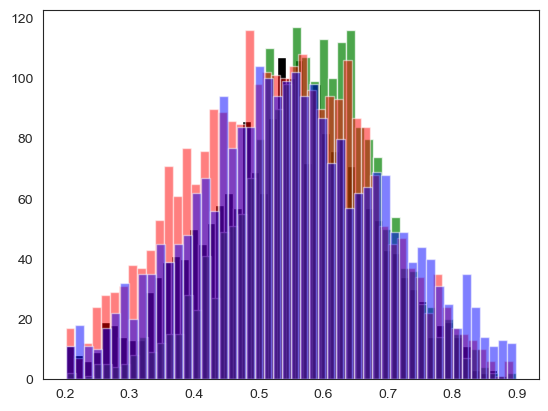

In [765]:
#df_buf = df_test.copy()
#df_buf = df_buf[df_buf['danceability'] > 0.2]
#df_buf = df_buf[df_buf['danceability'] < 0.9]
#print_feature(df_buf, 'danceability')

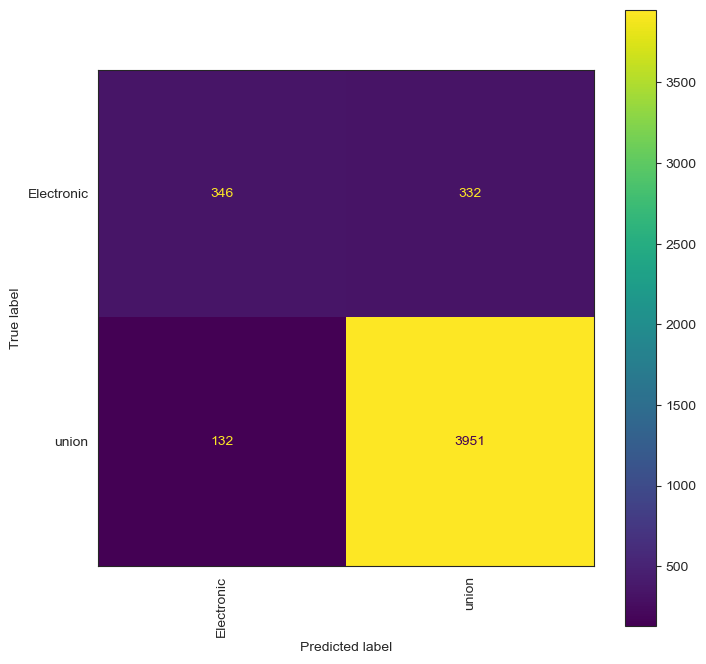

In [455]:
#class_names  = y_train.unique()
#fig, ax = plt.subplots(figsize=(8, 8))
#cmp = ConfusionMatrixDisplay(
#    confusion_matrix(y_test, y_pred),
#    display_labels=class_names
#)

#cmp.plot(ax=ax, xticks_rotation= 'vertical')
#plt.show();

In [279]:
CBC = CatBoostClassifier(
    iterations=150,
    random_seed=12345,
    loss_function='MultiClass',
)

pool_train = Pool(X_train, y_train, cat_features = ['key','mode'])
pool_test = Pool(X_test, y_test, cat_features = ['key','mode'])

CBC.fit(
    pool_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=False
)


y_pred = CBC.predict(pool_test)
round(fbeta_score(y_test, y_pred, average='macro', beta=0.5),5)

0.80345

In [225]:
df_buf['new_genre'].unique()

array(['union', 'Classical'], dtype=object)

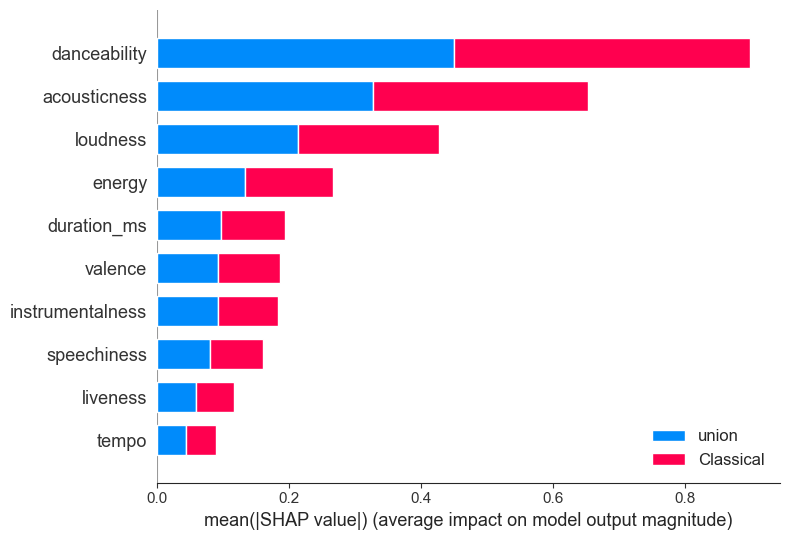

In [102]:
#import shap


#X = df_buf.drop('new_genre', axis = 1)
#explainer = shap.TreeExplainer(CBC)
#shap_values = explainer.shap_values(X)

#class_names  = df_buf['new_genre'].unique()
#shap.summary_plot(shap_values, X, plot_type='bar',  class_names= class_names, feature_names = X.columns)